# 시계열 분해, 인코더-디코더 LSTM 예측 모형

- 데이터 : 삼성의 005930.KS 주식 데이터
- input data : 시작가, 하한가, 상한가의 시계열 분해로 인한 성분을 각각의 인코더에 적합
- target data : 종가

---


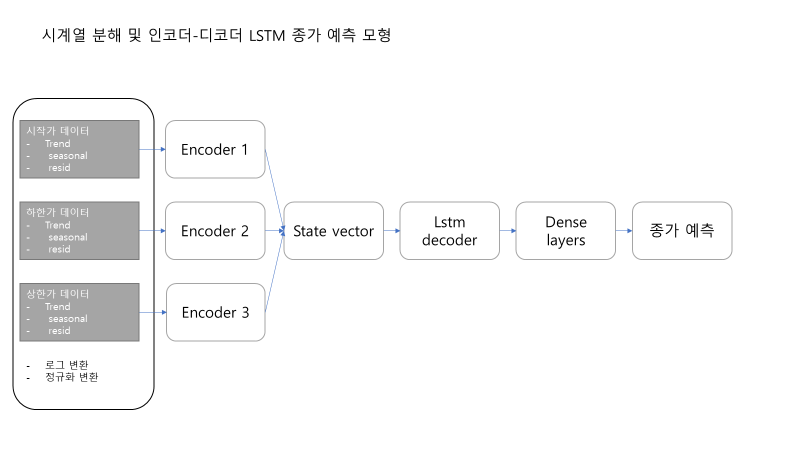

# import 및 read data

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam
import yfinance as yf

In [103]:
start_date = '2022-12-31'
end_date ='2024-12-31'

ticker = yf.Ticker('005930.KS')
 
df1= ticker.history(
               interval='1h',
               start=start_date,
               end=end_date,
               actions=True,
               auto_adjust=True)

In [109]:
X = df1.iloc[:,:4].loc[:'2023-11-30 14:00:00+09:00',:]
Y = df1.iloc[:,:4].loc['2023-12-01 10:00:00+09:00':,:]

In [280]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
minmax = MinMaxScaler()
norm = Normalizer()
data_scale= norm.fit_transform(np.log(X))
test_scale= norm.fit_transform(np.log(Y))

---

# train set 처리

In [171]:
result0 = seasonal_decompose(data_scale[:,0], model='additive', period=5)
result1 = seasonal_decompose(data_scale[:,1], model='additive', period=5)
result2 = seasonal_decompose(data_scale[:,2], model='additive', period=5)
result3 = seasonal_decompose(data_scale[:,3], model='additive', period=5)

In [253]:

s1= result0.seasonal[2:-2]
t1=result0.trend[2:-2]
r1=result0.resid[2:-2]

s2= result1.seasonal[2:-2]
t2=result1.trend[2:-2]
r2=result1.resid[2:-2]

s3= result2.seasonal[2:-2]
t3=result2.trend[2:-2]
r3=result2.resid[2:-2]

y = result3.observed[2:-2]
y.shape
s1.shape

(1350,)

In [202]:
class WINdow:
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
        window_df = self.df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self. window_df 

In [260]:
target= WINdow(pd.DataFrame(y),5)
target.window()
target.y_label.shape

(1345,)

In [243]:
# 시작가
open_0=WINdow(pd.DataFrame(s1),5)
open_0.window()
open_0.feature
open_1=WINdow(pd.DataFrame(t1),5)
open_1.window()
open_1.feature
open_2=WINdow(pd.DataFrame(r1),5)
open_2.window()
open_2.feature
# 하한가
low_0=WINdow(pd.DataFrame(s2),5)
low_0.window()
low_0.feature
low_1=WINdow(pd.DataFrame(t2),5)
low_1.window()
low_1.feature
low_2=WINdow(pd.DataFrame(r2),5)
low_2.window()
low_2.feature
# 상한가
high_0=WINdow(pd.DataFrame(s3),5)
high_0.window()
high_0.feature
high_1=WINdow(pd.DataFrame(t3),5)
high_1.window()
high_1.feature
high_2=WINdow(pd.DataFrame(r3),5)
high_2.window()
high_2.feature

# 인코더 형식 생성

lst0=[open_0.feature,open_1.feature,open_2.feature]
lst1=[low_0.feature,low_1.feature,low_2.feature]
lst2=[high_0.feature,high_1.feature,high_2.feature]

openreshape = [lst0[i].reshape(-1,5,1) for i in range(len(lst0))]
lowreshape = [lst1[i].reshape(-1,5,1) for i in range(len(lst1))]
highreshape = [lst2[i].reshape(-1,5,1) for i in range(len(lst2))]

encoder_X1 = np.concatenate([openreshape[0],openreshape[1],openreshape[2]],axis=2)
encoder_X2 = np.concatenate([lowreshape[0],lowreshape[1],lowreshape[2]],axis=2)
encoder_X3 = np.concatenate([highreshape[0],highreshape[1],highreshape[2]],axis=2)

encoder_X1.shape,encoder_X2.shape,encoder_X3.shape

((1345, 5, 3), (1345, 5, 3), (1345, 5, 3))

---

# test data

In [286]:
result0_ = seasonal_decompose(test_scale[:,0], model='additive', period=5)
result1_ = seasonal_decompose(test_scale[:,1], model='additive', period=5)
result2_ = seasonal_decompose(test_scale[:,2], model='additive', period=5)
result3_ = seasonal_decompose(test_scale[:,3], model='additive', period=5)

In [287]:

s1_= result0_.seasonal[2:-2]
t1_=result0_.trend[2:-2]
r1_=result0_.resid[2:-2]

s2_= result1_.seasonal[2:-2]
t2_=result1_.trend[2:-2]
r2_=result1_.resid[2:-2]

s3_= result2_.seasonal[2:-2]
t3_=result2_.trend[2:-2]
r3_=result2_.resid[2:-2]

y_ = result3_.observed[2:-2]
y_.shape,s1_.shape

((312,), (312,))

In [289]:
test= WINdow(pd.DataFrame(y_),5)
test.window()
test.y_label.shape

(307,)

In [290]:
# 시작가
open_0=WINdow(pd.DataFrame(s1_),5)
open_0.window()
open_0.feature
open_1=WINdow(pd.DataFrame(t1_),5)
open_1.window()
open_1.feature
open_2=WINdow(pd.DataFrame(r1_),5)
open_2.window()
open_2.feature
# 하한가
low_0=WINdow(pd.DataFrame(s2_),5)
low_0.window()
low_0.feature
low_1=WINdow(pd.DataFrame(t2_),5)
low_1.window()
low_1.feature
low_2=WINdow(pd.DataFrame(r2_),5)
low_2.window()
low_2.feature
# 상한가
high_0=WINdow(pd.DataFrame(s3_),5)
high_0.window()
high_0.feature
high_1=WINdow(pd.DataFrame(t3_),5)
high_1.window()
high_1.feature
high_2=WINdow(pd.DataFrame(r3_),5)
high_2.window()
high_2.feature

# 인코더 형식 생성

lst0=[open_0.feature,open_1.feature,open_2.feature]
lst1=[low_0.feature,low_1.feature,low_2.feature]
lst2=[high_0.feature,high_1.feature,high_2.feature]

openreshape = [lst0[i].reshape(-1,5,1) for i in range(len(lst0))]
lowreshape = [lst1[i].reshape(-1,5,1) for i in range(len(lst1))]
highreshape = [lst2[i].reshape(-1,5,1) for i in range(len(lst2))]

encoder_X1_ = np.concatenate([openreshape[0],openreshape[1],openreshape[2]],axis=2)
encoder_X2_ = np.concatenate([lowreshape[0],lowreshape[1],lowreshape[2]],axis=2)
encoder_X3_ = np.concatenate([highreshape[0],highreshape[1],highreshape[2]],axis=2)

encoder_X1_.shape,encoder_X2_.shape,encoder_X3_.shape

((307, 5, 3), (307, 5, 3), (307, 5, 3))

---

# 모델적합

- **2024-02-14의 실험 세팅과 동일하게 진행**

In [262]:
n1, n2 = 128, 256
dn1,dn2,dn3,dn4,dn5,dn6 = 256,128,64,32,16,8
feature1 = 3
feature2 = 3
feature3 = 3
#feature4 = 3
timestep = 5


################################################################################
# encoder1 
K.clear_session()
encoder_input1 = Input(shape=( timestep , feature1))
encoder1 = LSTM(units=n1,return_state=True,name ='encoder1')
_, encoder_h1, encoder_c1 = encoder1(encoder_input1)

#################################################################################
# encoder2
encoder_input2 = Input(shape=(timestep, feature2))
encoder2 = LSTM(units=n1, return_state=True,name ='encoder2')
_, encoder_h2, encoder_c2 = encoder2(encoder_input2)

#################################################################################
# encoder3
encoder_input3 = Input(shape=(timestep, feature3))
encoder3 = LSTM(units=n1, return_state=True,name ='encoder3')
_, encoder_h3, encoder_c3 = encoder3(encoder_input3)

# encoder1,2,3,4의 state vector
encoder_state = concatenate([encoder_h1, encoder_c1, 
                             encoder_h2, encoder_c2,
                            encoder_h3, encoder_c3], axis=-1)
################################################################################
#decoder
decoder = LSTM(units=n2,return_sequences=True,name ='decoder1')

decoder_output= decoder(K.expand_dims(encoder_state, axis=1))
d1 = Dense(dn1, activation='linear')(decoder_output)
d1_d = Dropout(0.15)(d1)

d2 = Dense(dn2, activation='linear')(d1_d)
d2_d = Dropout(0.01)(d2)

d3 = Dense(dn3, activation='linear')(d2)
d3_d = Dropout(0.01)(d3)

d4 = Dense(dn4, activation='linear')(d3)
d4_d = Dropout(0.01)(d4)

d5 = Dense(dn5, activation='linear')(d4)
d5_d = Dropout(0.01)(d5)

d6 =Dense(1, activation='linear')(d5)

#decoder_outputs = Dropout(0.2)(d6)
################################################################################
#model

model = Model(inputs=[encoder_input1, encoder_input2, encoder_input3 ], outputs=d6)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 3)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 5, 3)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 5, 3)]               0         []                            
                                                                                                  
 encoder1 (LSTM)             [(None, 128),                67584     ['input_1[0][0]']             
                              (None, 128),                                                    

In [263]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
epochs = 50
batch_size = 2

model.fit([encoder_X1,encoder_X2,encoder_X3],target.y_label, epochs=epochs, batch_size=batch_size
          ,callbacks=[early_stop])


Epoch 1/50
673/673 [==============================] - 10s 7ms/step - loss: 0.0024
Epoch 2/50
673/673 [==============================] - 5s 7ms/step - loss: 2.1024e-04
Epoch 3/50
673/673 [==============================] - 5s 7ms/step - loss: 1.5603e-04
Epoch 4/50
673/673 [==============================] - 5s 7ms/step - loss: 1.1739e-04
Epoch 5/50
673/673 [==============================] - 5s 7ms/step - loss: 7.3272e-05
Epoch 6/50
673/673 [==============================] - 5s 7ms/step - loss: 4.8751e-05
Epoch 7/50
673/673 [==============================] - 5s 7ms/step - loss: 2.1880e-05
Epoch 8/50
673/673 [==============================] - 5s 7ms/step - loss: 1.4384e-05
Epoch 9/50
673/673 [==============================] - 5s 7ms/step - loss: 6.4948e-06
Epoch 10/50
673/673 [==============================] - 5s 7ms/step - loss: 3.0426e-06
Epoch 11/50
673/673 [==============================] - 5s 7ms/step - loss: 2.0995e-06
Epoch 12/50
673/673 [==============================] - 5s 7ms/step

In [265]:
pred0= model.predict([encoder_X1,encoder_X2,encoder_X3])

43/43 [==============================] - 1s 2ms/step


5.910196142634955e-08


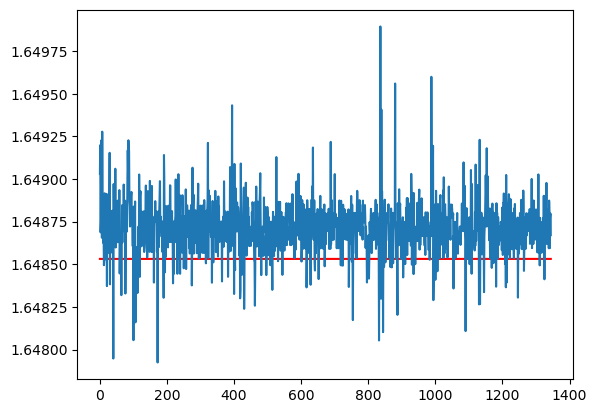

In [279]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(np.exp(pred0.flatten()),np.exp(target.y_label)))
plt.plot(np.exp(pred0.flatten()), color= 'red')
plt.plot(np.exp(target.y_label))

---

# test

In [295]:
pred1= model.predict([encoder_X1_,encoder_X2_,encoder_X3_])

10/10 [==============================] - 0s 2ms/step


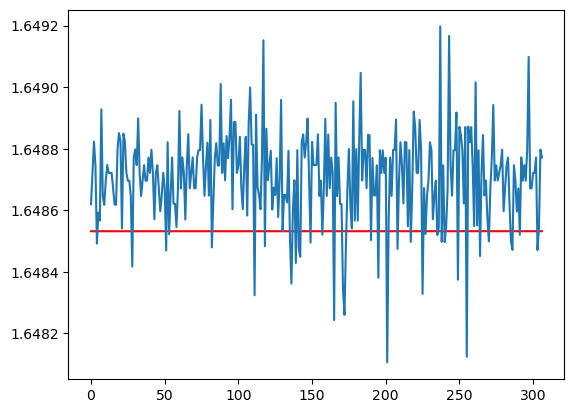

In [301]:
from sklearn.metrics import mean_squared_error
decom_lstm = mean_squared_error(np.exp(pred1.flatten()),np.exp(test.y_label))
#print(mean_squared_error(pred1.flatten(),test.y_label))

plt.plot(np.exp(pred1.flatten()), color= 'red')
plt.plot(np.exp(test.y_label))

In [315]:
# 다른 모델의 MSE 
# 2024-02-14- 자료의 결과
en_de_lstm = 0.002599030235042551
normal_lstm = 0.002824254216755877

print('시계열 분해 en-de LSTM : {:.9f}'.format(decom_lstm))
print('기존 방식의 en-de LSTM : {:.9f}'.format(en_de_lstm))
print('베이스라인 normal LSTM : {:.9f}'.format(normal_lstm))

시계열 분해 en-de LSTM : 0.000000053
기존 방식의 en-de LSTM : 0.002599030
베이스라인 normal LSTM : 0.002824254
